In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from lib.pandas_util import idxwhere
import sfacts as sf
import numpy as np
import xarray as xr
import seaborn as sns

In [5]:
data = (
    pd.read_table('data/ucfmt.filt-poly05-cvrg05.fit-sfacts44_v-s30-g5000-seed0.refit-sfacts41-g10000-seed0.all_scg_comparison.tsv')
    .assign(species_id=lambda x: x.species_id.astype(str))
    .assign(scg=lambda x: x.species_id + '_' + x.scg)
    .set_index('scg')
)

scg_cvrg_thresh = 0.05
mgen_entropy_thresh = 0.1
data = data[lambda x: (x.scg_horizontal_coverage > scg_cvrg_thresh) & (x['sample'].isin([
    'SS01009',
    'SS01057',
]))]

In [6]:
meta = pd.read_table('meta/sample.tsv', index_col='sample_id')
meta.loc[['SS01009', 'SS01057']]

,subject_id,collection_days_post_fmt,received_days_post_fmt,sample_type,sample_type_specific,dna_extraction_days_post_fmt,dna_sequencing_days_post_fmt,plate_well,sample_weight,source_sample_id,sample_notes,biosample
sample_id,,,,,,,,,,,,
SS01009,S0004,26.0,NaN,maintenance,pre_maintenance_4,264.0,294.0,1.A8,0.2687,DFS.1009,pre-e4,SAMN19715395
SS01057,S0024,-6.0,NaN,baseline,baseline,124.0,154.0,1.E1,0.1224,DFS.1057,Baseline,SAMN19715435


In [7]:
(data.mgen_entropy > 0.1).mean()

0.37376237623762376

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='x', ylabel='y'>

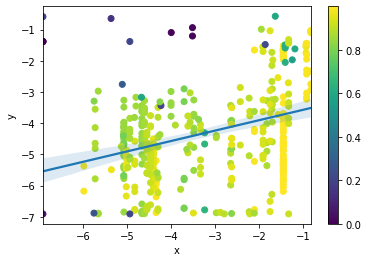

In [8]:
plt.scatter('x', 'y', c='c', data=data.assign(
    x=lambda x: np.log(x.mgen_entropy + 1e-3),
    y=lambda x: np.log(x.ddist_focal_mgen + 1e-3),
#     c=lambda x: x.fdist_focal_mgen / x.fdist_focal_strain,
    c=lambda x: x.mgen_horizontal_coverage,
))
plt.colorbar()

sns.regplot('x', 'y', data=data.assign(
    x=lambda x: np.log(x.mgen_entropy + 1e-3),
    y=lambda x: np.log(x.ddist_focal_mgen + 1e-3),
), scatter=False)



In [9]:
data.mdist_focal_strain.agg(('mean', 'median'))

mean      0.039125
median    0.013272
Name: mdist_focal_strain, dtype: float64

In [10]:
data.mdist_focal_mgen.agg(('mean', 'median'))

mean      0.037167
median    0.008715
Name: mdist_focal_mgen, dtype: float64

In [11]:
import scipy as sp

_mgen_entropy_thresh = 0.05


print(
    'mdist_mgen_high_vs_low',
    data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].mdist_focal_mgen.mean(),
    data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].mdist_focal_mgen.mean(),
    data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].mdist_focal_mgen.median(),
    data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].mdist_focal_mgen.median(),
    sp.stats.mannwhitneyu(
        data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].mdist_focal_mgen,
        data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].mdist_focal_mgen,
    )
)

print(
    'overall_comparison',
    data.mdist_focal_mgen.mean(),
    data.ndist_focal_strain.mean(),
    data.mdist_focal_mgen.median(),
    data.ndist_focal_strain.median(),
    sp.stats.wilcoxon(
        data.mdist_focal_mgen,
        data.ndist_focal_strain,
    )
)
print(
    'low_entropy',
    data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].mdist_focal_mgen.mean(),
    data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].ndist_focal_strain.mean(),
    data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].mdist_focal_mgen.median(),
    data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].ndist_focal_strain.median(),
    sp.stats.wilcoxon(
        data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].mdist_focal_mgen,
        data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].ndist_focal_strain,
    )
)
print(
    'high_entropy',
    data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].mdist_focal_mgen.mean(),
    data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].ndist_focal_strain.mean(),
    data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].mdist_focal_mgen.median(),
    data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].ndist_focal_strain.median(),
    sp.stats.wilcoxon(
        data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].mdist_focal_mgen,
        data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].ndist_focal_strain,
    )
)

mdist_mgen_high_vs_low 0.06946632560624326 0.011644544851640482 0.0222107318501336 0.006246109710413 MannwhitneyuResult(statistic=9679.5, pvalue=1.9607100368840404e-19)
overall_comparison 0.03716687700516839 0.031205067841269783 0.0087148069541065 0.0087050157205601 WilcoxonResult(statistic=1969.0, pvalue=0.0003366228097843666)
low_entropy 0.011644544851640482 0.012067516063436987 0.006246109710413 0.006502244018637551 WilcoxonResult(statistic=67.0, pvalue=0.091844728177532)
high_entropy 0.06946632560624326 0.055424342407566655 0.0222107318501336 0.0177912055877131 WilcoxonResult(statistic=1207.0, pvalue=0.00028439867146570926)


In [12]:
sp.stats.wilcoxon(
    data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].mdist_focal_mgen,
    data[lambda x: x.mgen_entropy > _mgen_entropy_thresh].ndist_focal_strain,
    alternative='greater',
)

WilcoxonResult(statistic=3071.0, pvalue=0.00014219933573285463)

In [13]:
sp.stats.wilcoxon(
    data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].mdist_focal_mgen,
    data[lambda x: x.mgen_entropy < _mgen_entropy_thresh].ndist_focal_strain,
    alternative='greater',
)

WilcoxonResult(statistic=67.0, pvalue=0.954077635911234)

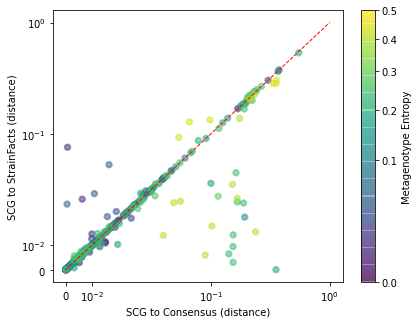

In [14]:
fig = plt.figure(figsize=(6.5, 5))

plt.scatter('mdist_focal_mgen', 'ndist_focal_strain', c='mgen_entropy', s=30, lw=2, marker='o', data=data.sort_values('mgen_entropy'), norm=mpl.colors.PowerNorm(1/2, vmin=0, vmax=0.5), alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.colorbar(label='Metagenotype Entropy')
plt.yscale('symlog', linthresh=1e-2, linscale=0.2)
plt.xscale('symlog', linthresh=1e-2, linscale=0.2)
plt.xlabel('SCG to Consensus (distance)')
plt.ylabel('SCG to StrainFacts (distance)')

fig.savefig('fig/scg_comparison_plus_entropy.pdf', dpi=400)

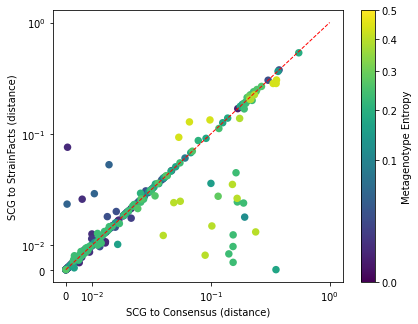

In [15]:
fig = plt.figure(figsize=(6.5, 5))

plt.scatter('mdist_focal_mgen', 'ndist_focal_strain', c='mgen_entropy', s=30, lw=2, marker='o', data=data.sort_values('mgen_entropy'), norm=mpl.colors.PowerNorm(1/2, vmin=0, vmax=0.5), alpha=1.0)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.colorbar(label='Metagenotype Entropy')
plt.yscale('symlog', linthresh=1e-2, linscale=0.2)
plt.xscale('symlog', linthresh=1e-2, linscale=0.2)
plt.xlabel('SCG to Consensus (distance)')
plt.ylabel('SCG to StrainFacts (distance)')

fig.savefig('fig/scg_comparison_plus_entropy_colorbar.pdf', dpi=400)

Text(0, 0.5, 'SCG to StrainFacts (distance)')

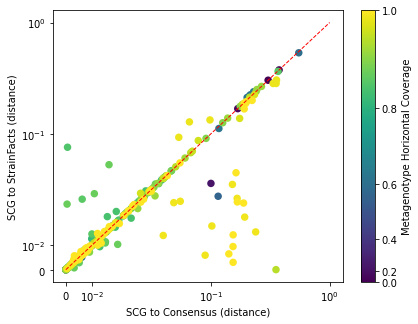

In [16]:
fig = plt.figure(figsize=(6.5, 5))

plt.scatter('mdist_focal_mgen', 'ndist_focal_strain', data=data.sort_values('mgen_horizontal_coverage'), s=30, c='mgen_horizontal_coverage', lw=2, marker='o', norm=mpl.colors.PowerNorm(2, vmin=0, vmax=1.0))
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.colorbar(label='Metagenotype Horizontal Coverage')
plt.yscale('symlog', linthresh=1e-2, linscale=0.2)
plt.xscale('symlog', linthresh=1e-2, linscale=0.2)
plt.xlabel('SCG to Consensus (distance)')
plt.ylabel('SCG to StrainFacts (distance)')

# fig.savefig('doc/static/scg_comparison_supplementary_figure.pdf', dpi=400)

Text(0, 0.5, 'SCG to StrainFacts (distance)')

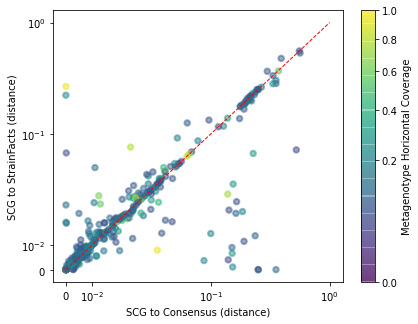

In [17]:
fig = plt.figure(figsize=(6.5, 5))

plt.scatter('ddist_focal_mgen', 'ddist_focal_strain', c='scg_horizontal_coverage', s=30, lw=2, marker='o', data=data.sort_values('mgen_horizontal_coverage'), norm=mpl.colors.PowerNorm(1/2, vmin=0, vmax=1.0), alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.colorbar(label='Metagenotype Horizontal Coverage')
plt.yscale('symlog', linthresh=1e-2, linscale=0.2)
plt.xscale('symlog', linthresh=1e-2, linscale=0.2)
plt.xlabel('SCG to Consensus (distance)')
plt.ylabel('SCG to StrainFacts (distance)')

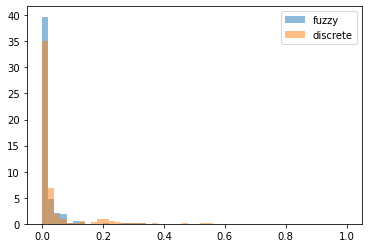

In [18]:
bins = np.linspace(0, 1.0, num=51)

plt.hist(data['fdist_focal_strain'], density=True, bins=bins, alpha=0.5, label='fuzzy')
plt.hist(data['ddist_focal_strain'], density=True, bins=bins, alpha=0.5, label='discrete')
# plt.hist(data[data.mgen_entropy_focal_mgen > 0.1]['smallest_ddist_focal_strains'], density=True, bins=bins, alpha=0.5, label='fit_high_entropy')
plt.legend()
# plt.yscale('log')

In [19]:
idxwhere( True
#     & ((data['smallest_ddist_focal_mgen'] / data['smallest_ddist_focal_strains']) > 1.5)
#     & (data['smallest_ddist_focal_strains'] < 1e-1)
    & (data['ddist_focal_mgen'] > 0.05)
    & (data['mgen_entropy'] > 0.05)
#     & (data['smallest_ddist_focal_mgen'] > 0.05)
)

['104345_SS01009_3',
 '104345_SS01009_11',
 '104345_SS01009_16',
 '104345_SS01009_44',
 '104345_SS01009_46',
 '104345_SS01009_47',
 '104345_SS01009_50',
 '104345_SS01009_76',
 '104345_SS01009_82',
 '104345_SS01009_99',
 '104345_SS01009_102',
 '104345_SS01009_109',
 '104345_SS01009_110',
 '104345_SS01009_112',
 '100199_SS01009_15',
 '100199_SS01009_16',
 '100199_SS01009_17',
 '100199_SS01009_23',
 '100199_SS01057_0',
 '100199_SS01057_2',
 '100199_SS01057_6',
 '100199_SS01057_19',
 '100199_SS01057_27',
 '100212_SS01009_0',
 '100212_SS01009_10',
 '100212_SS01009_12',
 '100212_SS01009_13',
 '100212_SS01009_14',
 '100271_SS01057_0',
 '100271_SS01057_1',
 '100271_SS01057_4',
 '101315_SS01009_3',
 '101315_SS01057_18',
 '101315_SS01057_19',
 '101315_SS01057_21',
 '100084_SS01057_16',
 '100084_SS01057_24',
 '100084_SS01057_25',
 '102444_SS01009_1',
 '102302_SS01009_0',
 '100113_SS01009_8',
 '100113_SS01009_9',
 '100113_SS01009_10',
 '100113_SS01009_11',
 '100113_SS01009_13',
 '100113_SS01009_14

In [20]:
focal_species = '100113'
mgen_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.nc'
scg_path = f'data/ucfmt.sp-{focal_species}.derep.genotype.nc'
fit_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.fit-sfacts42-s30-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc'
mgen = sf.data.Metagenotypes.load(mgen_path)
scg = sf.data.Metagenotypes.load(scg_path)
fit = sf.data.World.load(fit_path)

In [21]:
position = list(set(mgen.select_variable_positions(0.1).position.values) & set(scg.position.values) & set(fit.position.values))
nposition = min(1000, len(position))
position_ss = np.random.choice(position, size=nposition, replace=False)

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


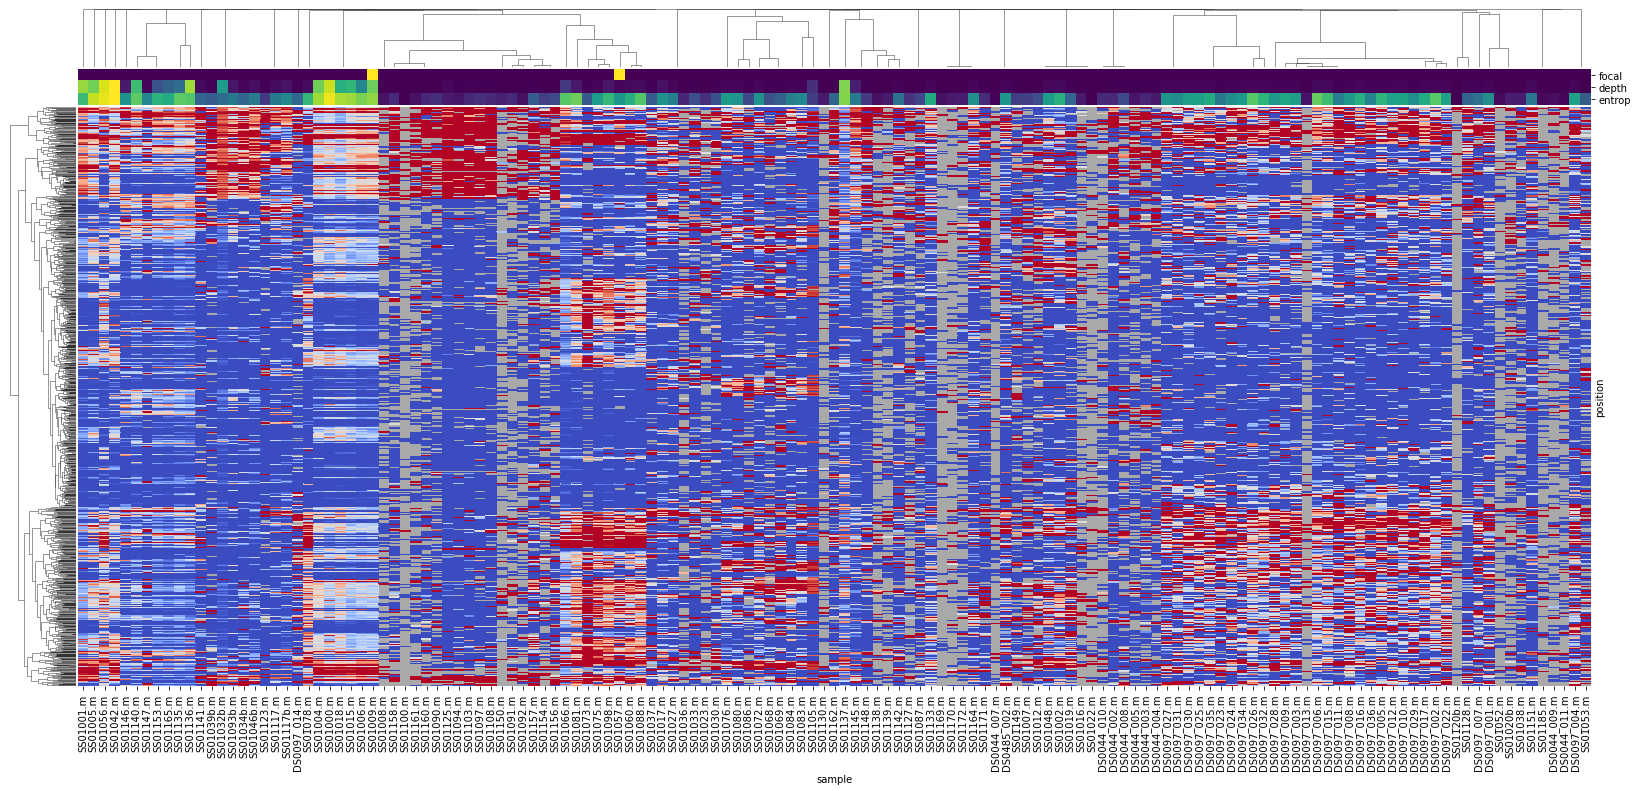

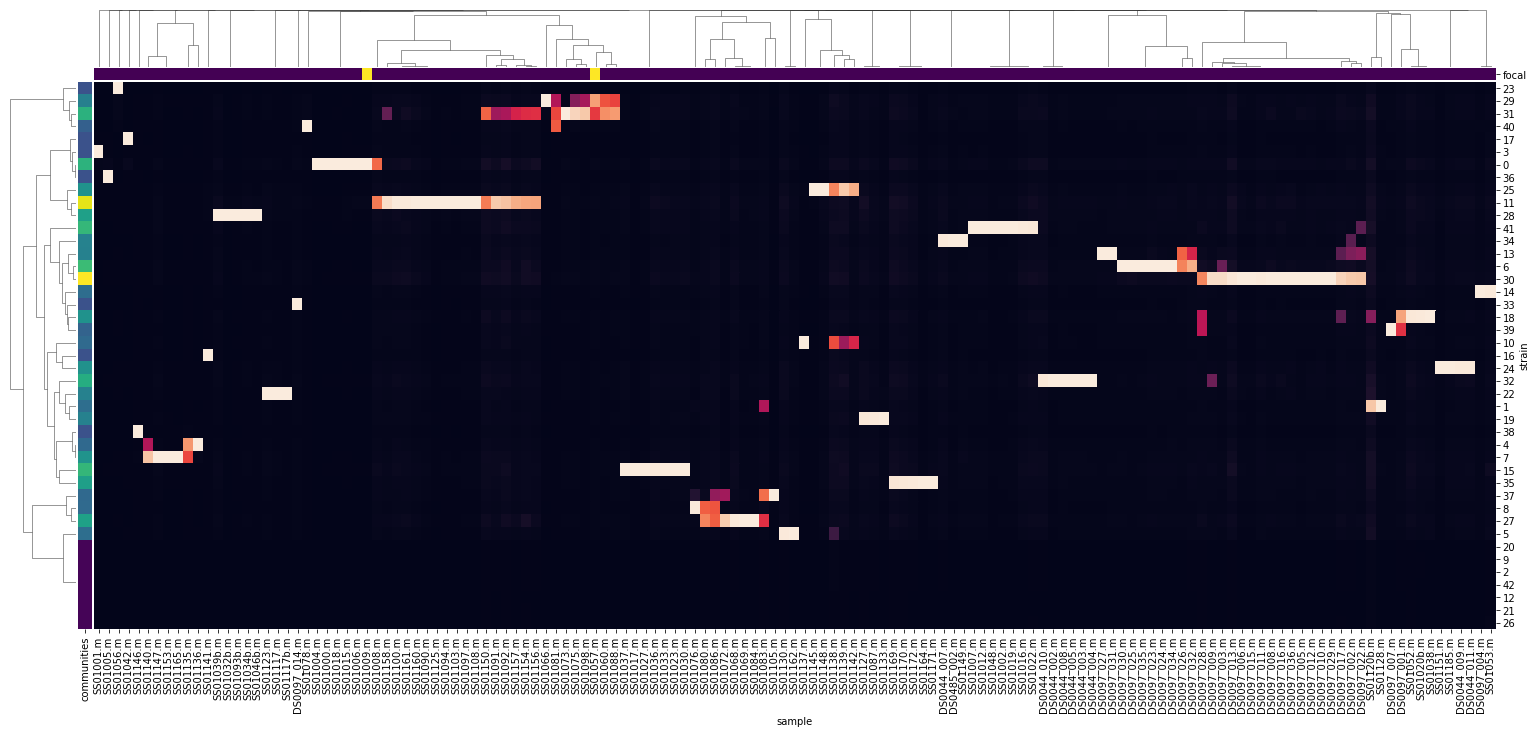

In [22]:
sf.plot.plot_metagenotype2(
    fit.sel(position=position_ss),
    col_linkage_func=lambda w: w.communities.linkage("sample"),
    row_linkage_func=lambda w: w.metagenotypes.linkage("position"),
    background_color='darkgrey',
    col_colors_func=lambda w: xr.Dataset(
        dict(
            focal=w.sample.isin(['SS01057.m', 'SS01009.m']),
            depth=w.metagenotypes.mean_depth(),
            entrop=w.metagenotypes.entropy(),
        )
    ),
#     scaley=2e-2 if nposition < 500 else 1e-3
)
sf.plot.plot_community(
    fit.sel(position=position_ss),
    col_linkage_func=lambda w: w.communities.linkage("sample"),
    row_linkage_func=lambda w: w.genotypes.linkage("strain"),
    col_colors_func=lambda w: xr.Dataset(
        dict(
            focal=w.sample.isin(['SS01057.m', 'SS01009.m']),
#             alpha=w.data.alpha,
        )
    ),
)

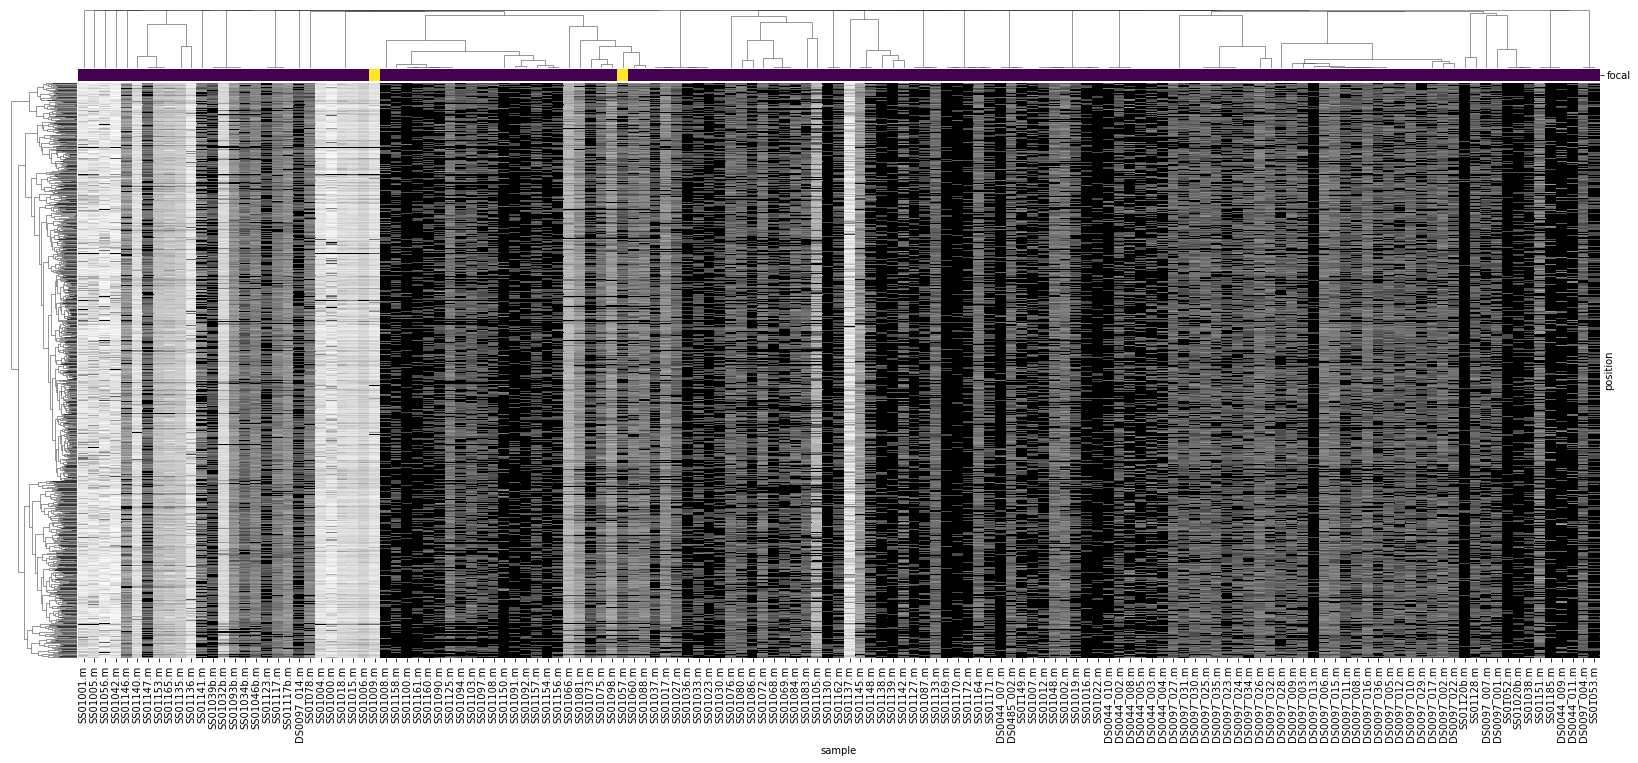

In [23]:
sf.plot.plot_depth(
    fit.sel(position=position_ss),
    col_linkage_func=lambda w: w.communities.linkage("sample"),
    row_linkage_func=lambda w: w.metagenotypes.linkage("position"),
    background_color='darkgrey',
    col_colors_func=lambda w: xr.Dataset(
        dict(
            focal=w.sample.isin(['SS01057.m', 'SS01009.m']),
        )
    ),
#     scaley=2e-2 if nposition < 500 else 1e-3
)

/pollard/home/bsmith/Projects/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))


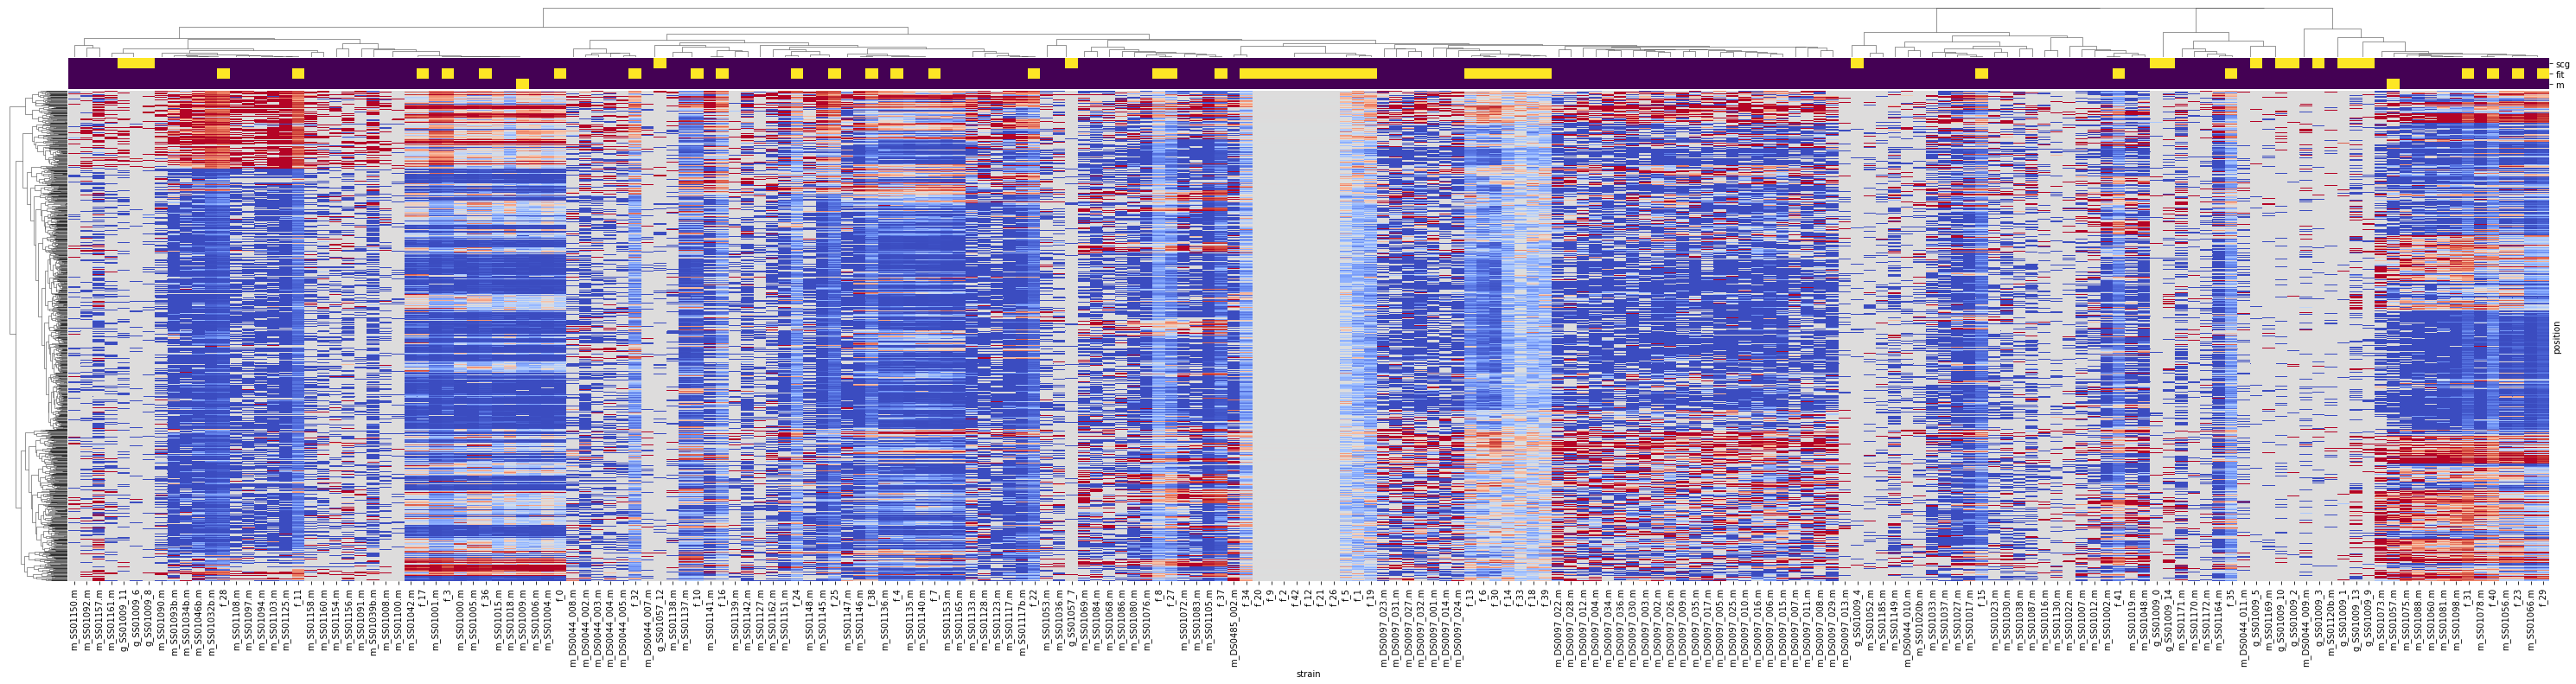

In [24]:
together = sf.data.Genotypes.concat(dict(
    m=mgen.to_estimated_genotypes(),
    g=scg.to_estimated_genotypes(),
    f=fit.genotypes,
), dim='strain')

sf.plot.plot_genotype(
    together.mlift('sel', position=position_ss),
    transpose=True,
    row_colors_func=lambda w: xr.Dataset(
        dict(
            scg=w.strain.str.startswith('g_'),
            fit=w.strain.str.startswith('f_'),
            m=w.strain.str.startswith('m_SS01009') | w.strain.str.startswith('m_SS01057'),

        )
    ),
    col_linkage_func=lambda w: fit.metagenotypes.mlift('sel', position=position_ss).linkage("position"),
#     scalex=2e-2 if nposition < 500 else 1e-3
)

In [25]:
from scipy.spatial.distance import cdist

# mgen_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.nc'
# scg_path = f'data/ucfmt.sp-{focal_species}.derep.genotype.nc'
# fit_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.fit-sfacts16-s40-g500-seed0.world.nc'
scg_to_sample_path = f'data/ucfmt.sp-{focal_species}.derep.barcode_to_sample.tsv'
library_to_sample_path = 'data/ucfmt.barcode_to_sample.tsv'
threshold = 0.01
pseudo = 1e-10

mgen = sf.data.Metagenotypes.load(mgen_path)
drplt = sf.data.Metagenotypes.load(scg_path)
inference = sf.data.World.load(fit_path)

mgen_consensus = mgen.to_estimated_genotypes(pseudo=pseudo)
scg = drplt.to_estimated_genotypes(pseudo=pseudo)
inferred_geno = inference.genotypes
inferred_comm = inference.communities

position = list(set(scg.position.values) & set(inferred_geno.position.values))
mgen_consensus, scg, inferred_geno = [
    x.mlift("sel", position=position) for x in [mgen_consensus, scg, inferred_geno]
]

# scg_to_sample = scg.strain.to_series().str.split("_").apply(lambda x: x[0]) + ".m"
library_to_sample = pd.read_table(
    library_to_sample_path, index_col="barcode", squeeze=True
)
scg_to_sample = pd.read_table(
    scg_to_sample_path, names=["strain", "sample"], index_col="strain", squeeze=True
)

smallest_fdist_all_strains = sf.match_genotypes(
    scg.to_world(), inferred_geno.to_world()
)[1]
smallest_ddist_all_strains = sf.match_genotypes(
    scg.to_world(), inferred_geno.discretized().to_world()
)[1]
smallest_fdist_all_mgen = sf.match_genotypes(
    scg.to_world(), mgen_consensus.to_world()
)[1]
smallest_ddist_all_mgen = sf.match_genotypes(
    scg.to_world(), mgen_consensus.discretized().to_world()
)[1]

scg_horizontal_coverage = (drplt.total_counts() > 0).mean("position")

smallest_fdist_focal_strains = []
smallest_ddist_focal_strains = []
smallest_cdist_focal_strains = []

smallest_fdist_focal_mgen = []
smallest_ddist_focal_mgen = []
smallest_cdist_focal_mgen = []

horizontal_coverage_focal_mgen = []
community_entropy_focal_sample = []

focal_sample_strain_list = {}
focal_sample_scg_list = {}
focal_sample_library_list = {}
focal_sample_strain_rabund = {}

for focal_sample, d in scg_to_sample.reset_index(name="sample").groupby("sample"):
    focal_sample_library_list[focal_sample] = idxwhere(
        (library_to_sample == focal_sample)
        & (library_to_sample.index.to_series().isin(inferred_comm.sample.values))
    )
    if not focal_sample_library_list[focal_sample]:
        continue
    focal_sample_scg_list[focal_sample] = scg_to_sample[scg_to_sample == focal_sample].index
    focal_sample_strain_rabund[focal_sample] = inferred_comm.sel(sample=focal_sample_library_list[focal_sample]).mean("sample").to_series()
    focal_sample_strain_list[focal_sample] = idxwhere(
        focal_sample_strain_rabund[focal_sample] > threshold
    )
    smallest_fdist_focal_strains.append(
        sf.match_genotypes(
            scg.mlift("sel", strain=focal_sample_scg_list[focal_sample]).to_world(),
            inferred_geno.mlift("sel", strain=focal_sample_strain_list[focal_sample]).to_world(),
        )[1]
    )
    smallest_ddist_focal_strains.append(
        sf.match_genotypes(
            scg.mlift("sel", strain=focal_sample_scg_list[focal_sample]).to_world(),
            inferred_geno.mlift("sel", strain=focal_sample_strain_list[focal_sample])
            .discretized()
            .to_world(),
        )[1]
    )
    smallest_cdist_focal_strains.append(
        sf.match_genotypes(
            scg.mlift("sel", strain=focal_sample_scg_list[focal_sample]).to_world(),
            inferred_geno.mlift("sel", strain=focal_sample_strain_list[focal_sample])
            .discretized()
            .to_world(),
            cdist=lambda x, y: cdist(x, y, metric='cityblock')
        )[1]
    )
    smallest_fdist_focal_mgen.append(
        sf.match_genotypes(
            scg.mlift("sel", strain=focal_sample_scg_list[focal_sample]).to_world(),
            mgen_consensus.mlift(
                "sel", strain=focal_sample_library_list[focal_sample]
            ).to_world(),
        )[1]
    )
    smallest_ddist_focal_mgen.append(
        sf.match_genotypes(
            scg.mlift("sel", strain=focal_sample_scg_list[focal_sample]).to_world(),
            mgen_consensus.mlift("sel", strain=focal_sample_library_list[focal_sample])
            .discretized()
            .to_world(),
        )[1]
    )
    smallest_cdist_focal_mgen.append(
        sf.match_genotypes(
            scg.mlift("sel", strain=focal_sample_scg_list[focal_sample]).to_world(),
            mgen_consensus.mlift("sel", strain=focal_sample_library_list[focal_sample])
            .discretized()
            .to_world(),
            cdist=lambda x, y: cdist(x, y, metric='cityblock')
        )[1]
    )
    horizontal_coverage_focal_mgen.append(
        pd.Series(
            float(
                (
                    mgen.total_counts()
                    .sel(sample=focal_sample_library_list[focal_sample])
                    .sum("sample")
                    > 0
                ).mean()
            ),
            index=d.strain,
        )
    )
    community_entropy_focal_sample.append(
        pd.Series(
            float(
                (
                    inferred_comm.entropy("sample")
                    .sel(sample=focal_sample_library_list[focal_sample])
                    .mean(
                        "sample"
                    )  # FIXME: The mean entropy across multiple replicate libraries isn't really what I care about ...
                )
            ),
            index=d.strain,
        )
    )

if smallest_fdist_focal_strains:
    smallest_fdist_focal_strains = pd.concat(smallest_fdist_focal_strains)
else:
    smallest_fdist_focal_strains = np.nan
if smallest_ddist_focal_strains:
    smallest_ddist_focal_strains = pd.concat(smallest_ddist_focal_strains)
else:
    smallest_ddist_focal_strains = np.nan
if smallest_cdist_focal_strains:
    smallest_cdist_focal_strains = pd.concat(smallest_cdist_focal_strains)
else:
    smallest_cdist_focal_strains = np.nan
if smallest_fdist_focal_mgen:
    smallest_fdist_focal_mgen = pd.concat(smallest_fdist_focal_mgen)
else:
    smallest_fdist_focal_mgen = np.nan
if smallest_ddist_focal_mgen:
    smallest_ddist_focal_mgen = pd.concat(smallest_ddist_focal_mgen)
else:
    smallest_ddist_focal_mgen = np.nan
if smallest_cdist_focal_mgen:
    smallest_cdist_focal_mgen = pd.concat(smallest_cdist_focal_mgen)
else:
    smallest_cdist_focal_mgen = np.nan
if horizontal_coverage_focal_mgen:
    horizontal_coverage_focal_mgen = pd.concat(horizontal_coverage_focal_mgen)
else:
    horizontal_coverage_focal_mgen = np.nan
if community_entropy_focal_sample:
    community_entropy_focal_sample = pd.concat(community_entropy_focal_sample)
else:
    community_entropy_focal_sample = np.nan

out = pd.DataFrame(
    dict(
        smallest_fdist_all_strains=smallest_fdist_all_strains,
        smallest_ddist_all_strains=smallest_ddist_all_strains,
        smallest_fdist_all_mgen=smallest_fdist_all_mgen,
        smallest_ddist_all_mgen=smallest_ddist_all_mgen,
        smallest_fdist_focal_strains=smallest_fdist_focal_strains,
        smallest_ddist_focal_strains=smallest_ddist_focal_strains,
        smallest_cdist_focal_strains=smallest_cdist_focal_strains,
        smallest_fdist_focal_mgen=smallest_fdist_focal_mgen,
        smallest_ddist_focal_mgen=smallest_ddist_focal_mgen,
        smallest_cdist_focal_mgen=smallest_cdist_focal_mgen,
        scg_horizontal_coverage=scg_horizontal_coverage,
        horizontal_coverage_focal_mgen=horizontal_coverage_focal_mgen,
        community_entropy_focal_sample=community_entropy_focal_sample,
    )
).rename_axis(index="scg")

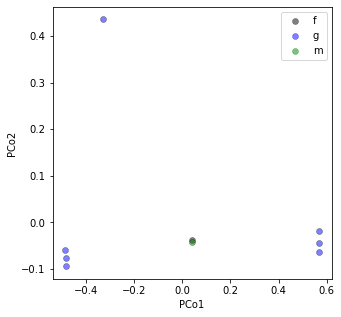

In [26]:
import lib.plot

focal_sample = 'SS01009'
m = mgen_consensus.mlift('sel', strain=focal_sample_library_list[focal_sample])#.discretized()
g = drplt.mlift('sel', position=scg.position).select_samples_with_coverage(0.05).to_estimated_genotypes(pseudo=1.0)
f = inferred_geno.mlift('sel', strain=focal_sample_strain_list[focal_sample])#.discretized()

together = sf.data.Genotypes.concat(dict(
    m=m, g=g, f=f
), dim='strain')

fig, ax = plt.subplots(figsize=(5, 5))

ax, ordin, *_ = lib.plot.ordination_plot(
    together.pdist(),
    ordin=lib.plot.nmds_ordination,
    meta=pd.DataFrame(dict(
        t=together.strain.str[0],
    ), index=together.strain).fillna(-1),
    colorby='t',
#     color_palette=drplt_ucfmt_104345_strain_type_palette,
#     markerby='is_est',
#     marker_palette={True: '>', False: 'o'},
#     zorderby='is_est',
#     markersizeby='is_est',
#     markersize_palette={True: 60, False: 40},
    ordin_kws={'is_dmat': True},
#     fill_legend=False,
    scatter_kws=dict(lw=0.5, alpha=0.5),
    ax=ax
)

ax.set_xlabel('PCo1')
ax.set_ylabel('PCo2')

ordin['gtype'] = ordin.index.to_series().str.split('_').apply(lambda x: x[0])
for name, d1 in ordin[ordin.gtype.isin(['est', 'mgen'])].iterrows():
    ax.annotate(name, xy=d1[['PC1', 'PC2']].to_list())
None

/pollard/home/bsmith/Projects/StrainFacts/sfacts/plot.py:155: UserWarning: row_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"row_linkage calculation failed: {err}")


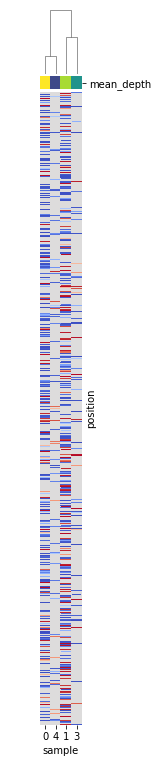

In [27]:
from sklearn.cluster import AgglomerativeClustering

_drplt = drplt.mlift('sel', position=scg.position)#.select_samples_with_coverage(0.05)#.to_estimated_genotypes(pseudo=1.0)
gdist = _drplt.pdist("sample")
assert gdist.isna().sum().sum() == 0

clust = pd.Series(
    AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=0.1, affinity='precomputed').fit_predict(gdist),
    index=gdist.index,
)

clust_drplt = sf.data.Metagenotypes(
    _drplt.to_series().unstack('sample').T.groupby(clust).sum().T.stack().rename_axis(['position', 'allele', 'sample']).reorder_levels(['sample', 'position', 'allele']).to_xarray()
)

sf.plot_metagenotype(
    clust_drplt.select_samples_with_coverage(0.1).random_sample(position=1000)
)
# sf.plot_depth(
#     clust_drplt.select_samples_with_coverage(0.05).random_sample(position=1000)
# )

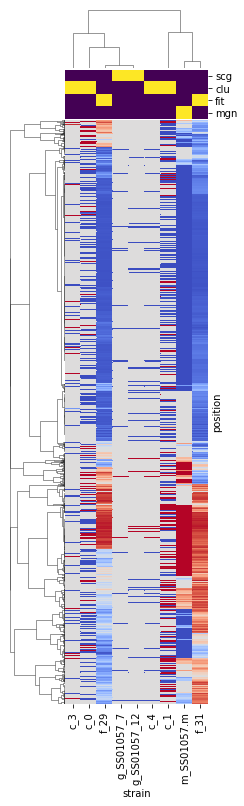

In [28]:
focal_sample = 'SS01057'
m = mgen_consensus.mlift('sel', strain=focal_sample_library_list[focal_sample])#.discretized()
g = scg.mlift('sel', strain=focal_sample_scg_list[focal_sample])
f = inferred_geno.mlift('sel', strain=focal_sample_strain_list[focal_sample])#.discretized()
c = clust_drplt.select_samples_with_coverage(0.1).to_estimated_genotypes(pseudo=pseudo)


together = sf.data.Genotypes.concat(dict(
    m=m,
    g=g,
    f=f,
    c=c,
), dim='strain')

nposition = min(10000, len(together.position))


sf.plot.plot_genotype(
    together.random_sample(position=nposition),
    row_colors_func=lambda w: xr.Dataset(
        dict(
            scg=w.strain.str.startswith('g_'),
            clu=w.strain.str.startswith('c_'),
            fit=w.strain.str.startswith('f_'),
            mgn=w.strain.str.startswith('m_'),
        )
    ),
    col_linkage_func=lambda w: w.genotypes.mlift('sel', strain=w.strain.str.startswith('f_') | w.strain.str.startswith('m_')).linkage("position"),
    transpose=True,
    scalex=1e-3,
)

In [29]:
focal_sample_strain_list

{'SS01009': [0], 'SS01057': [29, 31]}

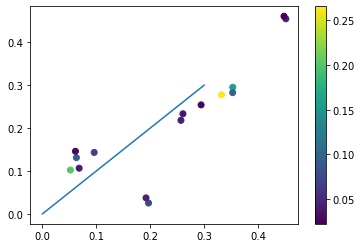

In [30]:
plt.scatter('smallest_ddist_focal_mgen', 'smallest_ddist_focal_strains', c='scg_horizontal_coverage', data=out)
plt.colorbar()
# plt.yscale('log')
# plt.xscale('log')
plt.plot([0, 0.3], [0, 0.3])

(0.0, 400.0)

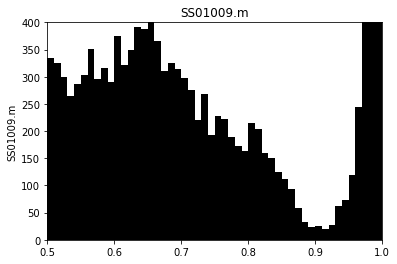

In [31]:
mgen_filt = (
    mgen
    .select_variable_positions(thresh=0.05)
    .select_samples_with_coverage(0.0)
)

fig, ax = plt.subplots()

sf.plot.plot_metagenotype_frequency_spectrum(mgen_filt.to_world(), sample_list=['SS01009.m'], axs=ax, bins=np.linspace(0.5, 1.0, num=51), show_predict=False)
# ax.set_yscale('log')
ax.set_ylim(0, 400)